In [35]:
# Parameter block (edit these before running anything else)
CONFIG = {
    "repo_url": "https://github.com/wppqywq/CLIP_text_encoder.git",  # GitHub repo to clone
    "repo_branch": "main",
    "repo_dir": "/content/comp545_final_github",
    "drive_mount": "/content/drive",
    "data_root": "/content/drive/MyDrive/comp545_data",
    "output_root": "/content/drive/MyDrive/comp545_outputs",
    "env": "colab",
    "packages": [
        "open-clip-torch",
        "torch",
        "torchvision",
        "pillow",
        "numpy",
        "matplotlib",
        "pandas",
        "tqdm",
    ],
    "smoke_limit": 1000,  # number of images for the quick smoke test
    "smoke_distill": (0.2, 0.7),
    "smoke_output": "vg_smoke",
    "full_limit": None,  # set to None for the full dataset
    "full_distill": (0.0, 0.2, 0.7),
    "full_output": "vg_full",
    "adapter_steps": 300,
    "adapter_batch": 64,
    "chunk_words": 8,
    "chunk_stride": 4,
    "chunk_threshold": 15,
    "text_pooling": "attn",
    "show_progress": True,
}



In [36]:
# Install dependencies (no-op if already satisfied)
if CONFIG["packages"]:
    import subprocess
    import sys

    cmd = [sys.executable, "-m", "pip", "install", "--quiet", *CONFIG["packages"]]
    subprocess.run(cmd, check=True)
else:
    print("No extra packages listed.")


In [37]:
# Mount Google Drive and clone the repository if needed
import subprocess, shutil
from pathlib import Path

from google.colab import drive

MOUNT_POINT = Path(CONFIG["drive_mount"])
if not MOUNT_POINT.is_dir():
    drive.mount(str(MOUNT_POINT))

repo_dir = Path(CONFIG["repo_dir"]).resolve()
shutil.rmtree(repo_dir, ignore_errors=True)
# if not repo_dir.exists():
if 1:
    repo_dir.parent.mkdir(parents=True, exist_ok=True)
    clone_cmd = [
        "git",
        "clone",
        CONFIG["repo_url"],
        str(repo_dir),
        "--branch",
        CONFIG["repo_branch"],
        "--single-branch",
    ]
    subprocess.run(clone_cmd, check=True)
else:
    print(f"Repo already present at {repo_dir}")


In [38]:
# Configure project paths and ensure modules import correctly
import os
import sys

from pathlib import Path

repo_root = Path(CONFIG["repo_dir"]).resolve()
data_root = Path(CONFIG["data_root"]).resolve()
output_root = Path(CONFIG["output_root"]).resolve()

os.environ["VG_COLAB_REPO_ROOT"] = str(repo_root)
os.environ["VG_COLAB_DATA_ROOT"] = str(data_root)
os.environ["VG_COLAB_OUTPUT_ROOT"] = str(output_root)

repo_root.mkdir(parents=True, exist_ok=True)
data_root.mkdir(parents=True, exist_ok=True)
output_root.mkdir(parents=True, exist_ok=True)

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print("repo_root:", repo_root)
print("data_root:", data_root)
print("output_root:", output_root)


repo_root: /content/comp545_final_github
data_root: /content/drive/MyDrive/comp545_data
output_root: /content/drive/MyDrive/comp545_outputs


In [39]:
import zipfile
from pathlib import Path

if 0:
  # Define paths based on user query
  zip_path = Path("/content/drive/MyDrive/comp545_data/visual_genome_raw.zip")
  target_dir = Path("/content/drive/MyDrive/comp545_data/")

  # Ensure the target directory exists
  target_dir.mkdir(parents=True, exist_ok=True)

  if zip_path.is_file():
      print(f"Extracting {zip_path} to {target_dir}")
      with zipfile.ZipFile(zip_path, 'r') as zf:
          zf.extractall(target_dir)
      print("Extraction complete.")
  else:
      print(f"Error: Zip file not found at {zip_path}")

In [40]:
# Optional helper: unzip image archives from Drive into the expected directory

if 0:
  zip_map = {
      "images.zip": data_root / "visual_genome" / "images",
      "images2.zip": data_root / "visual_genome" / "images",
  }

  for zip_name, target_dir in zip_map.items():
      archive_path = data_root / "visual_genome_raw" / zip_name
      if not archive_path.is_file():
          print(f"Archive not found: {archive_path}")
          continue
      target_dir.mkdir(parents=True, exist_ok=True)
      with zipfile.ZipFile(archive_path, "r") as zf:
          print(f"Extracting {zip_name} -> {target_dir}")
          zf.extractall(target_dir)
  print("Done extracting image archives.")


## Dataset Checklist
Ensure Drive contains the Visual Genome archives under `CONFIG['data_root']`:
```
visual_genome_raw/
  region_descriptions.json (or .zip)
  image_data.json (or .zip)
  VG_100K.zip
  VG_100K_2.zip
visual_genome/
  images/VG_100K/
  images/VG_100K_2/
```
If you already processed splits elsewhere, copy `visual_genome/visual_genome_splits.json` here. Otherwise, run the next cell to prepare everything from scratch.


In [41]:
import os
test_path = os.path.join(CONFIG["data_root"], "visual_genome/images/VG_100K/2.jpg")
!ls -lh "$test_path"

-rw------- 1 root root 92K Nov 17 15:37 /content/drive/MyDrive/comp545_data/visual_genome/images/VG_100K/2.jpg


In [42]:
# Optional: download/process/verify Visual Genome (set RUN_PROCESS=True when needed)
RUN_PROCESS = 1
PROCESS_CONFIG = {
    "max_images": 5000,
    "max_regions_per_image": 6,
    "min_region_words": 3,
    "validation_ratio": 0.1,
    "test_ratio": 0.1,
    "seed": 42,
}

if RUN_PROCESS:
    from src.config.runtime import resolve_paths
    from src.data.visual_genome import (
        VisualGenomeProcessConfig,
        download_visual_genome,
        process_visual_genome,
        verify_visual_genome,
    )

    # paths = resolve_paths("colab")
    paths = resolve_paths(CONFIG.get("env", "colab"))
    process_cfg = VisualGenomeProcessConfig(**PROCESS_CONFIG)
    # download_visual_genome(paths, include_images=True, force=False)
    processed_path = process_visual_genome(paths, process_cfg)
    print("Processed splits saved to:", processed_path)
    verify_visual_genome(paths)
else:
    print("Skipping data preparation. Toggle RUN_PROCESS=True if required.")


Saving processed dataset to /content/drive/MyDrive/comp545_data/visual_genome/visual_genome_splits.json...
Processed splits saved to: /content/drive/MyDrive/comp545_data/visual_genome/visual_genome_splits.json
Visual Genome verification succeeded.


In [43]:
# Inspect processed dataset statistics
import json

splits_path = data_root / "visual_genome" / "visual_genome_splits.json"
if splits_path.is_file():
    with splits_path.open("r", encoding="utf-8") as f:
        vg_payload = json.load(f)
    counts = vg_payload.get("counts", {})
    splits = vg_payload.get("splits", {})
    print("Processed dataset counts:", counts)
    for name, entries in splits.items():
        size = len(entries) if isinstance(entries, list) else 0
        print(f"  {name}: {size} images")
else:
    print(f"Processed splits not found at {splits_path}; run the preparation cell if needed.")

Processed dataset counts: {'total': 5000, 'train': 4000, 'val': 500, 'test': 500}
  train: 4000 images
  val: 500 images
  test: 500 images


In [47]:
# Helper utilities for running experiments and plotting metrics
from typing import Iterable

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from src.config.runtime import resolve_paths
from src.training.vg_adapter import AdapterExperimentConfig, run_visual_genome_adapter


def run_experiment(limit, distill_weights: Iterable[float], output_name: str):
    config = AdapterExperimentConfig(
        output_name=output_name,
        limit_images=limit,
        distill_weights=tuple(distill_weights),
        adapter_steps=CONFIG["adapter_steps"],
        adapter_batch=CONFIG["adapter_batch"],
        chunk_words=CONFIG["chunk_words"],
        chunk_stride=CONFIG["chunk_stride"],
        chunk_threshold=CONFIG["chunk_threshold"],
        text_pooling=CONFIG["text_pooling"],
        device_preference=CONFIG.get("device", "cuda"),
        # show_progress=CONFIG.get("show_progress", False),

    )
    paths = resolve_paths(CONFIG.get("env", "colab"))
    print("Using device:", config.device_preference)
    results = run_visual_genome_adapter(paths, config)
    metrics_path = results.get("metrics_path")
    print("Metrics stored at:", metrics_path)
    summary_df = pd.DataFrame(results["summary"])
    return results, summary_df


def _collect_value_columns(summary_df: pd.DataFrame):
    base_cols = ["baseline", "chunk_baseline"]
    adapter_cols = sorted(col for col in summary_df.columns if col.startswith("adapter_"))
    return [col for col in base_cols + adapter_cols if col in summary_df]


def plot_summary(summary_df: pd.DataFrame, title: str):
    value_cols = _collect_value_columns(summary_df)
    melted = summary_df.melt(
        id_vars=["metric", "split"],
        value_vars=value_cols,
        var_name="variant",
        value_name="recall",
    )
    splits = sorted(melted["split"].unique())
    fig, axes = plt.subplots(len(splits), 1, figsize=(8, 4 * len(splits)), sharex=True)
    if len(splits) == 1:
        axes = [axes]
    for ax, split in zip(axes, splits):
        sub = melted[melted["split"] == split]
        pivot = sub.pivot(index="metric", columns="variant", values="recall")
        for variant in pivot.columns:
            ax.plot(pivot.index, pivot[variant], marker="o", label=variant)
        ax.set_title(f"{split} split")
        ax.set_ylabel("Recall (%)")
        ax.grid(alpha=0.3)
    axes[-1].set_xlabel("Metric")
    axes[0].legend()
    fig.suptitle(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_distribution(summary_df: pd.DataFrame, title: str):
    value_cols = _collect_value_columns(summary_df)
    plt.figure(figsize=(8, 4))
    for col in value_cols:
        plt.hist(summary_df[col], bins=10, alpha=0.4, label=col)
    plt.title(title)
    plt.xlabel("Recall (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



In [48]:

def plot_loss_logs(results: dict, title: str):
    loss_logs = results.get("loss_logs")
    if not loss_logs:
        print("No loss logs recorded.")
        return
    fig, (ax_loss, ax_scale) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    for weight_key, entries in loss_logs.items():
        if not entries:
            continue
        df = pd.DataFrame.from_records(entries, columns=["step", "loss", "scale"])
        if df.empty:
            continue
        label = f"distill={weight_key}"
        ax_loss.plot(df["step"], df["loss"], marker="o", label=label)
        ax_scale.plot(df["step"], df["scale"], marker="o", label=label)
    ax_loss.set_title("Adapter loss")
    ax_loss.set_xlabel("Step")
    ax_loss.set_ylabel("Loss")
    ax_loss.grid(alpha=0.3)
    ax_scale.set_title("Logit scale")
    ax_scale.set_xlabel("Step")
    ax_scale.set_ylabel("Scale")
    ax_scale.grid(alpha=0.3)
    ax_loss.legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def summarize_best_metrics(summary_df: pd.DataFrame):
    if summary_df.empty:
        print("Summary is empty.")
        return
    adapter_cols = [col for col in summary_df.columns if col.startswith("adapter_")]
    if not adapter_cols:
        print("No adapter columns found; ensure the training cell ran successfully.")
        display(summary_df.head())
        return
    melted = summary_df.melt(
        id_vars=["split", "metric", "baseline", "chunk_baseline"],
        value_vars=adapter_cols,
        var_name="variant",
        value_name="adapter_score",
    )
    best_rows = melted.loc[melted.groupby(["split", "metric"])["adapter_score"].idxmax()].sort_values(["split", "metric"])
    display(best_rows[["split", "metric", "variant", "adapter_score", "baseline", "chunk_baseline"]])

def show_test_metrics(results: dict, weight: float):
    adapter_metrics = results.get("adapter_metrics", {})
    block = adapter_metrics.get(weight)
    if not block:
        print(f"No metrics found for distill={weight}.")
        return
    print(f"Test metrics for distill={weight}:")
    test_df = pd.DataFrame.from_dict(block.get("test", {}), orient="index")
    display(test_df)



## 3. Smoke Test
Run a smaller experiment to confirm everything is wired correctly. This keeps runtime manageable before committing to the full dataset.


In [49]:
smoke_results, smoke_summary = run_experiment(
    limit=CONFIG["smoke_limit"],
    distill_weights=CONFIG["smoke_distill"],
    output_name=CONFIG["smoke_output"],
)
print("Smoke test metrics head:")
print(smoke_summary.head())


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Metrics stored at: /content/drive/MyDrive/comp545_outputs/vg_smoke/metrics.json
Smoke test metrics head:
   split  metric  baseline  chunk_baseline  adapter_0.20  adapter_0.70
0  train   t2i@1  0.117500        0.117500      0.117500      0.117500
1  train   t2i@5  0.264000        0.263833      0.263833      0.263833
2  train  t2i@10  0.355333        0.355167      0.355167      0.355167
3  train   i2t@1  0.240000        0.239000      0.239000      0.239000
4  train   i2t@5  0.458000        0.458000      0.458000      0.458000


,split,metric,variant,adapter_score,baseline,chunk_baseline
3,test,i2t@1,adapter_0.20,0.278000,0.278000,0.278000
5,test,i2t@10,adapter_0.20,0.602000,0.604000,0.602000
4,test,i2t@5,adapter_0.20,0.508000,0.504000,0.508000
0,test,t2i@1,adapter_0.20,0.138000,0.138667,0.138000
2,test,t2i@10,adapter_0.20,0.433333,0.433667,0.433333
1,test,t2i@5,adapter_0.20,0.320667,0.321000,0.320667


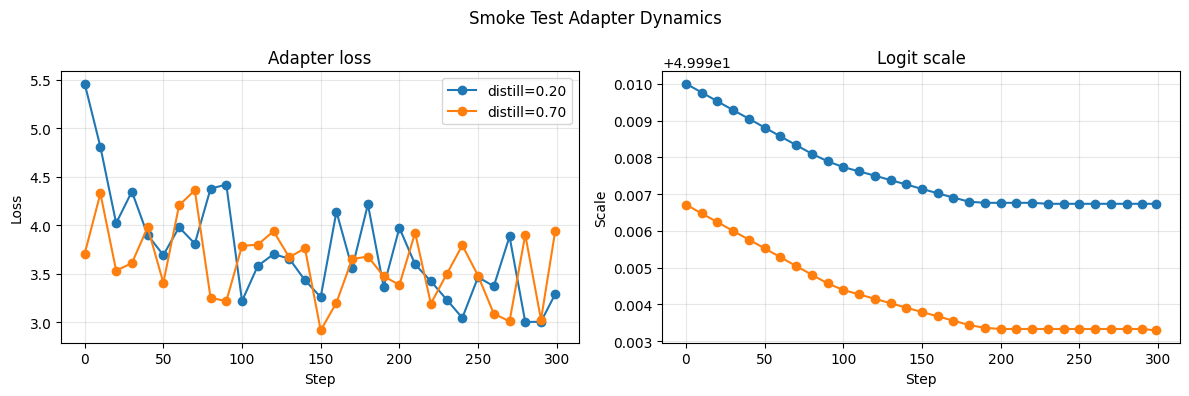

Test metrics for distill=0.7:


,1,5,10
t2i,0.138,0.320667,0.433333
i2t,0.278,0.508000,0.602000


In [50]:
summarize_best_metrics(smoke_summary.loc[smoke_summary["split"] == "test"])
plot_loss_logs(smoke_results, title="Smoke Test Adapter Dynamics")
if CONFIG["smoke_distill"]:
    show_test_metrics(smoke_results, CONFIG["smoke_distill"][-1])

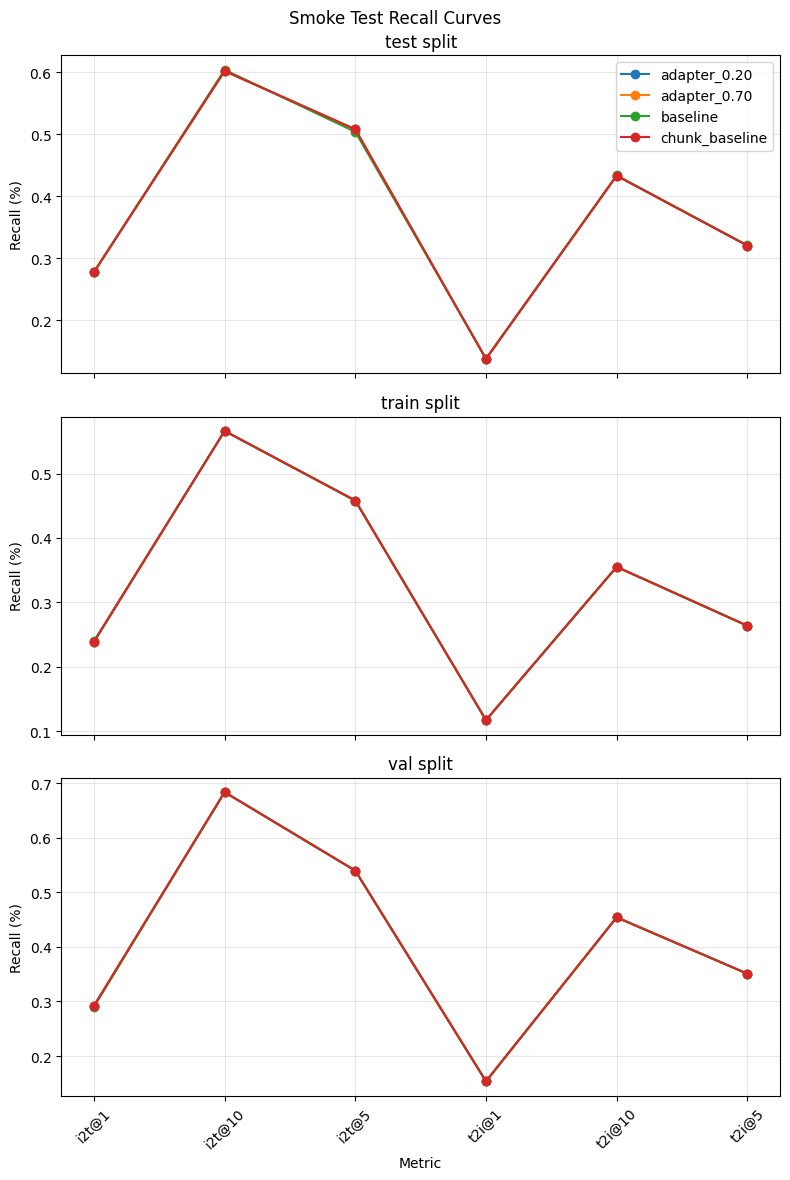

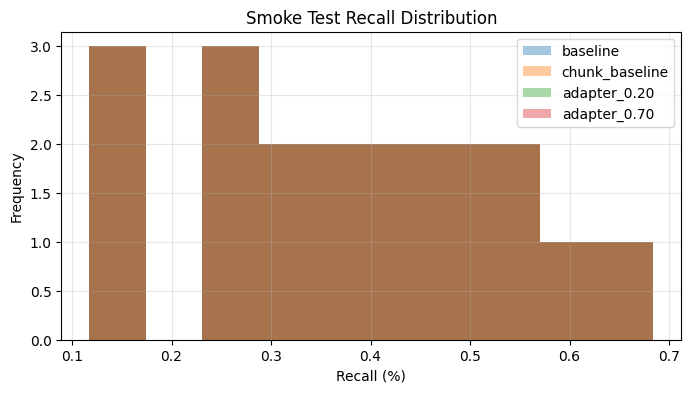

In [51]:
plot_summary(smoke_summary, title="Smoke Test Recall Curves")
plot_distribution(smoke_summary, title="Smoke Test Recall Distribution")


## 4. Full Experiment
Once the smoke test looks good, launch the full dataset run below. This may take significantly longer.


In [52]:
full_results, full_summary = run_experiment(
    limit=CONFIG["full_limit"],
    distill_weights=CONFIG["full_distill"],
    output_name=CONFIG["full_output"],
)
print("Full run metrics head:")
print(full_summary.head())


Using device: cuda


KeyboardInterrupt: 

In [ ]:
summarize_best_metrics(full_summary.loc[full_summary["split"] == "test"])
plot_loss_logs(full_results, title="Full Experiment Adapter Dynamics")
if CONFIG["full_distill"]:
    show_test_metrics(full_results, CONFIG["full_distill"][-1])

In [ ]:
plot_summary(full_summary, title="Full Experiment Recall Curves")
plot_distribution(full_summary, title="Full Experiment Recall Distribution")


## 5. Compare Smoke vs Full
The cell below merges both runs (if available) to compare adapter performance.


In [ ]:
def merge_runs(smoke_df: pd.DataFrame, full_df: pd.DataFrame) -> pd.DataFrame:
    smoke_df = smoke_df.copy()
    smoke_df["run"] = "smoke"
    full_df = full_df.copy()
    full_df["run"] = "full"
    return pd.concat([smoke_df, full_df], ignore_index=True)

if "smoke_summary" in globals() and "full_summary" in globals():
    combined = merge_runs(smoke_summary, full_summary)
    display(combined.head())
    value_cols = _collect_value_columns(smoke_summary)
    for split in sorted(combined["split"].unique()):
        subset = combined[combined["split"] == split]
        fig, ax = plt.subplots(figsize=(10, 4))
        positions = list(range(len(value_cols)))
        width = 0.35
        smoke_vals = [float(subset[subset["run"] == "smoke"][col].mean()) for col in value_cols]
        full_vals = [float(subset[subset["run"] == "full"][col].mean()) for col in value_cols]
        ax.bar([p - width / 2 for p in positions], smoke_vals, width=width, label="smoke")
        ax.bar([p + width / 2 for p in positions], full_vals, width=width, label="full")
        ax.set_xticks(positions)
        ax.set_xticklabels(value_cols, rotation=45)
        ax.set_ylabel("Mean Recall (%)")
        ax.set_title(f"Smoke vs Full comparison ({split} split)")
        ax.grid(alpha=0.3, axis="y")
        ax.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Both smoke_summary and full_summary must be available to compare.")


## 6. Wrap Up
- Push code changes back to GitHub once satisfied.
- Large data stays on Drive; processed results land under `CONFIG['output_root']`.
- Adjust the configuration cell at the top to try different adapters, chunking strategies, or distillation weights.
